# Analyze the readings from the accelerometer/gyroscope to fit gyroscopic acceleration in the z-direction and linear acceleration in the x-direction.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.style.use('default')

In [2]:
path = input('file name: ')

# turn all the data into numpy arrays
names = 'count, timestamp, x_accel, y_accel, z_accel, x_gyro, y_gyro, z_gyro'
all_data = np.genfromtxt(path, names = names, skip_footer = 1)

file name:  C:\Users\mhanr\Downloads\sidexu4.txt


In [3]:
# these calibration factors came from the calibration of device taped to wall,
# where I took one reading with the x-axis facing up and one
# with the x-axis facing down
x_sensitivity = 16351.4205
M_S_2_PER_BIT = 0.0005994292667111093

g_m_s2 = 9.80152 # from https://www.ngs.noaa.gov/cgi-bin/grav_pdx.prl using my local coordinates and altitude

gs_per_bit = M_S_2_PER_BIT * g_m_s2
# so for linear acceleration, we can convert the bits to g's
timestamp = all_data['timestamp']
x_accel = all_data['x_accel']/x_sensitivity
y_accel = all_data['y_accel']/x_sensitivity
z_accel = all_data['z_accel']/x_sensitivity # all three should now be in g's
z_gyro_bits = all_data['z_gyro']

In [4]:
# define functions designed for scipy's curve fit that can guess paramters
def x_accel_to_fit(t, g, ka, d, e, f):
    return g *np.exp(-ka*t)* np.cos( (d*np.cos(w*t)+e*np.sin(w*t)) ) + f
def theta_accel(t, k, w, a, b, c):
    return np.exp(-k*t) * ( w * ( a * np.cos(w*t) + b * np.sin(w*t) ) ) + c

In [5]:
# this is where the actual fitting begins
popt0_guesses =  [1, .1, 1, 1, np.average(x_accel)]
popt1_guesses = [.01, 4, 2500, 2500, np.average(z_gyro_bits)]

popt1, pcov1 = curve_fit(theta_accel, timestamp, z_gyro_bits, popt1_guesses)
w = popt1[1] # needed for the next fit!
popt0, pcov0 = curve_fit(x_accel_to_fit, timestamp, x_accel)

Text(0, 0.5, 'Gyroscopic Acceleration (bits)')

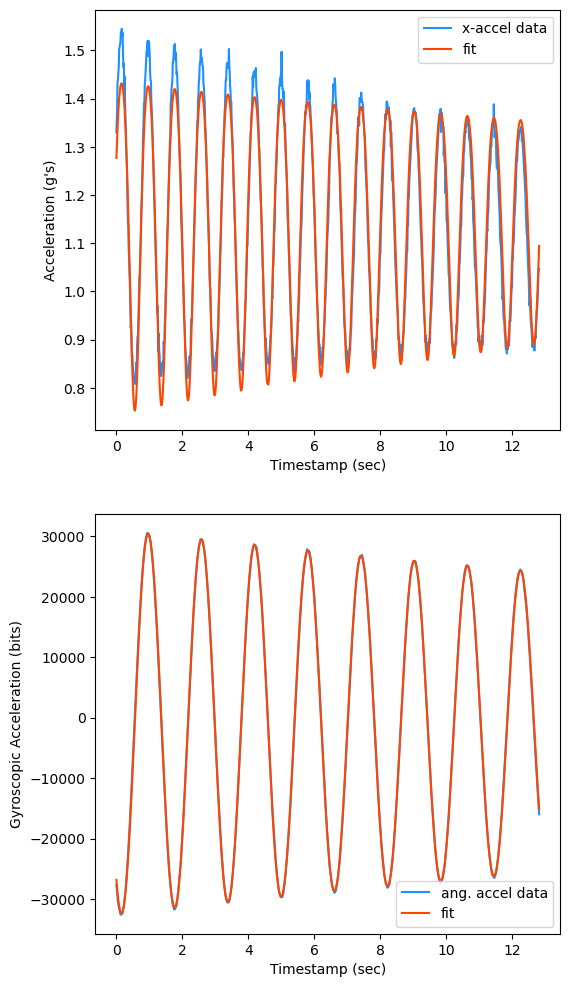

In [6]:
# plot the fits
accel_fit = x_accel_to_fit(timestamp, *popt0)
rad_accel_fit = theta_accel(timestamp, *popt1)
fig, ax = plt.subplots(2,1, figsize = (6,12))

ax[0].plot(timestamp, x_accel, c = 'dodgerblue', label = 'x-accel data')
ax[0].plot(timestamp, accel_fit, c= 'orangered', label = 'fit')
ax[0].legend()
ax[0].set_xlabel('Timestamp (sec)')
ax[0].set_ylabel("Acceleration (g's)")

ax[1].plot(timestamp, z_gyro_bits, c = 'dodgerblue', label = 'ang. accel data')
ax[1].plot(timestamp, rad_accel_fit, c= 'orangered', label = 'fit')
ax[1].legend()
ax[1].set_xlabel('Timestamp (sec)')
ax[1].set_ylabel('Gyroscopic Acceleration (bits)')

In [7]:
# print and guess the fit parameters:
print('x acceleration:')
titles = ['x accel amplitude', 'damping coef', 'a', 'b', 'height']
units = ["g's", '/s', 'bits', 'bits', "g's"]
for i in range(len(titles)):
    print(titles[i], ': ', popt0[i] , '+/-', pcov0[i][i]**0.5, units[i])
print('\nrad accel:')
titles2 = ['damping coef', 'ang freq', 'd', 'e', 'height']
units2 = ['/s', 'rad/s', 'bits', 'bits', 'bits']
for i in range(len(titles2)):
    print(titles2[i], ': ', popt1[i] , '+/-', pcov1[i][i]**0.5, units2[i])

x acceleration:
x accel amplitude :  -0.4433698611752496 +/- 0.008668544762623787 g's
damping coef :  0.031079888322469242 +/- 0.001597383226043152 /s
a :  1.7670693791164018 +/- 0.02781167559861346 bits
b :  1.2342644996395282 +/- 0.019914624443846847 bits
height :  1.1884110108446722 +/- 0.007912353237560675 g's

rad accel:
damping coef :  0.019166073743605773 +/- 0.00017949875910041119 /s
ang freq :  3.8965887976273397 +/- 0.0001763184207426745 rad/s
d :  -6678.305796082793 +/- 10.176594458257378 bits
e :  -4668.37182278457 +/- 9.957483667547343 bits
height :  -740.9110762992767 +/- 12.99998680976021 bits


In [8]:
# this cell is the back-of-envelope calculations Dr. Gaitan showed in our teams meeting 6/7
L = g_m_s2/popt1[1]**2
max_gz_bits = popt1[1]*np.sqrt(popt1[2]**2+popt1[3]**2)
Axmin = min(x_accel)*x_sensitivity
theta0 = np.cos(Axmin/x_sensitivity)
gz_max_rad_s = theta0*popt1[1]
max_gz_bits = popt1[1]*np.sqrt(popt1[2]**2+popt1[3]**2)
z_sensitivity = np.degrees(gz_max_rad_s)/ (max_gz_bits)
datasheet_sensitivity = .004375

print('L: ', L, 'm')
print('Max Gz:', max_gz_bits, 'bits')
print('Ax min:', Axmin)
print('theta0:', theta0, 'rad,', np.degrees(theta0), 'deg')
print('Gz max:', gz_max_rad_s, 'rad/s, ', np.degrees(gz_max_rad_s), 'deg/s')
print('z-sensitivity: ', z_sensitivity, 'dps/bits')
print('datasheet: ', datasheet_sensitivity)
print('ratio: ', (datasheet_sensitivity - z_sensitivity)/ (z_sensitivity))

L:  0.6455416607226329 m
Max Gz: 31750.256702485956 bits
Ax min: 13216.0
theta0: 0.6907664541845622 rad, 39.578002453992355 deg
Gz max: 2.6916328271523238 rad/s,  154.21920099469398 deg/s
z-sensitivity:  0.0048572583976185316 dps/bits
datasheet:  0.004375
ratio:  -0.09928613183415935
